In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from scipy import stats
from scipy.stats import beta

from conformal_utils import *
from fit_betas import beta_MoM, beta_variance

%load_ext autoreload
%autoreload 2

**Inputs:**
* softmax scores and labels
* $n_k$: Number of instances of each class to use when estimating $D$
* $n_k^{tune}$: Number of instances of each class to include in set used to tune the conformal parameter

**Output:**
Conformal prediction sets generated using the following methodology:
1. Fit a Beta distribution to the scores of the $n_k$ instances of class $k$ to get noisy $\alpha_k, \beta_k$ estimates
1. Let the prior $D$ be the KDE fit to the noisy $\alpha_k, \beta_k$ pairs
% 1. Let $\widehat{q}_k^{EB}$ be the ($1-\alpha$)%-quantile of $p(s_{k,new}|s_k,D)$
% 1. Apply conformal adjustment to $\widehat{q}_k^{EB}$
1. Find $\tilde{\alpha}$ such that, if we let $\widehat{q}_k$ be the ($1-\tilde{\alpha}$)%-quantile of $p(s_{k,new} | s_k, D)$, the prediction sets on the $1000 n_k^{tune}$ tuning points achieve a marginal coverage of $1-\alpha$ 
1. Generate prediction sets on unseen data using conformalized qhats

In [2]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [3]:
%%time

scores_all = 1 - softmax_scores

CPU times: user 897 ms, sys: 2.23 s, total: 3.12 s
Wall time: 3.14 s


In [4]:
alpha = .1
n_k = 5 
n_k_tune = 1
num_samples = 10000 # Number of Monte Carlo samples for estimating quantile of posterior score distribution
num_classes = 1000 # Number of classes in ImageNet

In [5]:
%%time

# Split into calibration data and validation data
calib_scores_all, calib_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_k + n_k_tune, num_classes=1000, seed=0)

# Split calibration into
#   1. Data to use for estimating D
#   2. Data to use for computing conformal adjustment
scores1_all, labels1, scores2_all, labels2 = split_X_and_y(calib_scores_all, calib_labels, n_k, num_classes=1000, seed=0)

CPU times: user 2.91 s, sys: 52.2 s, total: 55.1 s
Wall time: 56.8 s


In [6]:
%%time

# Only select data for which k is true class
scores1 = np.array([scores1_all[row,labels1[row]] for row in range(len(labels1))])

CPU times: user 3.4 ms, sys: 0 ns, total: 3.4 ms
Wall time: 3.41 ms


## 1. Estimate noisy $\alpha_k, \beta_k$

In [7]:
est_alphas = np.zeros((num_classes,))
est_betas = np.zeros((num_classes,))

for k in range(num_classes):
    class_k_scores = scores1[labels1==k]
    
    est_alpha, est_beta = beta_MoM(class_k_scores)
    
    print(f"[Class {k}] Est. params: {est_alpha:.2f}, {est_beta:.2f} || Associated variance: {beta_variance(est_alpha, est_beta):.3f}")
#     print(beta.fit(class_k_scores, method='MLE')[:2])
    
    est_alphas[k] = est_alpha
    est_betas[k] = est_beta

[Class 0] Est. params: 0.31, 49.76 || Associated variance: 0.000
[Class 1] Est. params: 0.75, 13.83 || Associated variance: 0.003
[Class 2] Est. params: 0.86, 3.16 || Associated variance: 0.033
[Class 3] Est. params: 0.29, 0.65 || Associated variance: 0.110
[Class 4] Est. params: 0.01, 0.04 || Associated variance: 0.153
[Class 5] Est. params: 0.91, 0.72 || Associated variance: 0.094
[Class 6] Est. params: 0.32, 3.61 || Associated variance: 0.015
[Class 7] Est. params: 0.12, 0.27 || Associated variance: 0.156
[Class 8] Est. params: 0.06, 0.20 || Associated variance: 0.139
[Class 9] Est. params: 0.34, 10.63 || Associated variance: 0.003
[Class 10] Est. params: 0.13, 0.78 || Associated variance: 0.066
[Class 11] Est. params: 0.27, 1.51 || Associated variance: 0.046
[Class 12] Est. params: 0.07, 0.10 || Associated variance: 0.203
[Class 13] Est. params: 0.22, 0.94 || Associated variance: 0.071
[Class 14] Est. params: 0.37, 18.03 || Associated variance: 0.001
[Class 15] Est. params: 0.43, 2

[Class 421] Est. params: 0.80, 1.19 || Associated variance: 0.080
[Class 422] Est. params: 0.97, 0.80 || Associated variance: 0.090
[Class 423] Est. params: 0.09, 0.17 || Associated variance: 0.178
[Class 424] Est. params: 0.70, 1.19 || Associated variance: 0.080
[Class 425] Est. params: 0.34, 7.50 || Associated variance: 0.005
[Class 426] Est. params: 0.15, 0.73 || Associated variance: 0.075
[Class 427] Est. params: 0.49, 0.92 || Associated variance: 0.094
[Class 428] Est. params: 0.41, 0.34 || Associated variance: 0.141
[Class 429] Est. params: 0.04, 0.14 || Associated variance: 0.150
[Class 430] Est. params: 0.02, 0.08 || Associated variance: 0.152
[Class 431] Est. params: 0.76, 3.41 || Associated variance: 0.029
[Class 432] Est. params: 0.27, 0.79 || Associated variance: 0.092
[Class 433] Est. params: 0.24, 0.47 || Associated variance: 0.131
[Class 434] Est. params: 1.61, 5.81 || Associated variance: 0.020
[Class 435] Est. params: 0.23, 0.49 || Associated variance: 0.127
[Class 436

[Class 573] Est. params: 0.83, 75.51 || Associated variance: 0.000
[Class 574] Est. params: 0.86, 13.89 || Associated variance: 0.003
[Class 575] Est. params: 0.50, 29.38 || Associated variance: 0.001
[Class 576] Est. params: 1.10, 93.82 || Associated variance: 0.000
[Class 577] Est. params: 0.12, 0.34 || Associated variance: 0.134
[Class 578] Est. params: 0.35, 0.52 || Associated variance: 0.129
[Class 579] Est. params: 0.32, 0.69 || Associated variance: 0.107
[Class 580] Est. params: 0.17, 0.14 || Associated variance: 0.189
[Class 581] Est. params: 0.17, 0.42 || Associated variance: 0.131
[Class 582] Est. params: 0.17, 0.09 || Associated variance: 0.182
[Class 583] Est. params: 0.02, 0.07 || Associated variance: 0.155
[Class 584] Est. params: 0.64, 4.03 || Associated variance: 0.021
[Class 585] Est. params: 0.21, 0.47 || Associated variance: 0.127
[Class 586] Est. params: 0.03, 0.14 || Associated variance: 0.133
[Class 587] Est. params: 0.56, 0.31 || Associated variance: 0.123
[Class

[Class 997] Est. params: 0.11, 0.28 || Associated variance: 0.145
[Class 998] Est. params: 0.55, 0.29 || Associated variance: 0.123
[Class 999] Est. params: 0.47, 0.35 || Associated variance: 0.134


In [8]:
save_to = '.cache/noisy_beta_params.csv'
df = pd.DataFrame({'alpha': est_alphas, 'beta': est_betas})
df.to_csv(save_to, index=False)
print(f'Saved noisy estimates of Beta parameters to {save_to}')

Saved noisy estimates of Beta parameters to .cache/noisy_beta_params.csv


#### Debugging

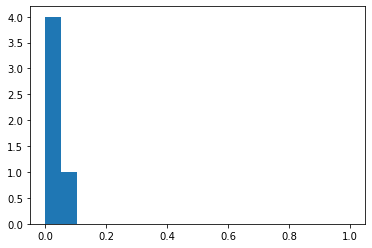

In [9]:
k = 51
bins = np.linspace(0, 1, 20)
plt.hist(scores1[labels1==k], bins=bins, density=False)

# xs = np.linspace(0,1,100)
# plt.plot(xs,beta.pdf(xs, a=est_alphas[k], b=est_betas[k]))

plt.show()

In [10]:
scores1[labels1==k]

array([0.0033229 , 0.00820959, 0.00382304, 0.00414497, 0.0965842 ])

There are some classes that the model always predicts correctly within our small n=20 sample, so all of the conformal scores are concentrated near 0. This makes it so the Beta distribution that is fit is weird. 

## 2. Define prior $D$
Fit KDE to noisy $\alpha_k, \beta_k$.

Comment: It seems like KDE is very sensitive to outliers

Some of the $\alpha_k, \beta_k$ estimates are quite extreme. This generally happens when the sampled scores are all close to 0. 

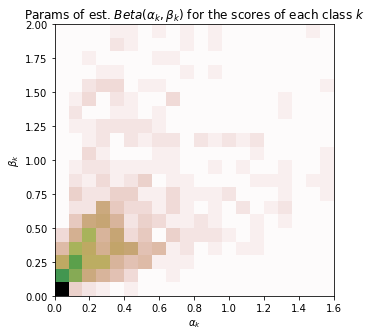

In [11]:
# (Optional) Visualize
xmin, xmax = 0, 1.6
ymin, ymax = 0, 2
bins = 20
plt.figure(figsize=(5,5))
cts, xedges, yedges, img = plt.hist2d(est_alphas, est_betas, 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()

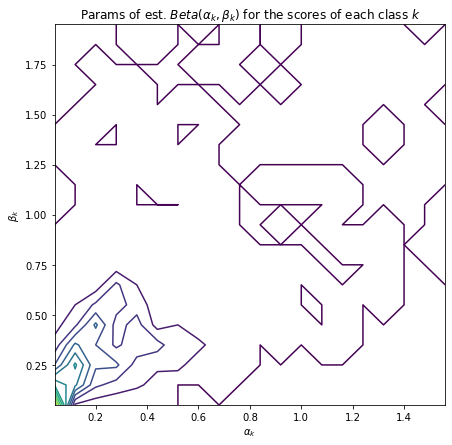

In [12]:
# (Optional) Contour plot visualization 
X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)

plt.figure(figsize=(7,7))
plt.contour(X, Y, cts.T, levels=12)
plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()

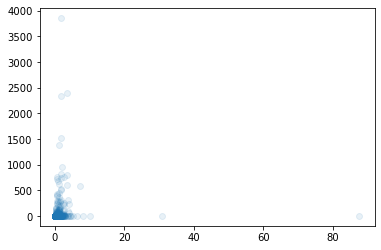

In [13]:
plt.scatter(est_alphas, est_betas, alpha=0.1)
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
# plt.show()

There are definitely some outliers!

#### Option 1: Apply KDE to all data

In [14]:
# # Apply KDE to smooth
# values = np.vstack([est_alphas, est_betas])
# kernel = stats.gaussian_kde(values)


bins=50
cts, xedges, yedges, img = plt.hist2d(est_alphas, est_betas, 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.close()

X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
positions = np.vstack([X.ravel(), Y.ravel()])

kernel = stats.gaussian_kde(positions, weights=cts.T.ravel())

In [15]:
# Visualize
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

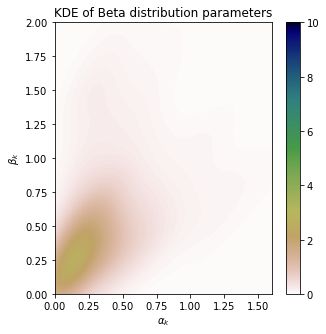

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               vmin=0, vmax=10, 
               cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

This looks like a more diffuse version of the oracle KDE from `imagenet_experiments.ipynb`

#### Option 2: Exclude outliers before applying KDE

Question: What criteria should we use for determining what is an outlier?
* Option 1: Let threshold be mean + 2 std devs
* Option 2: Let threshold be 99% quantile (I think I will go with this for now)

In [17]:
mean_est_betas = np.mean(est_betas)
sd_est_betas = np.std(est_betas)
print(f'Mean of estimated betas: {mean_est_betas:.3f}')
print(f'Std dev of estimated betas: {sd_est_betas:.3f}')

Mean of estimated betas: 32.833
Std dev of estimated betas: 194.879


In [18]:
est_betas_quantile = np.quantile(est_betas, .99)
print(f'99% quantile of estimated betas: {est_betas_quantile:.3f}')

99% quantile of estimated betas: 745.274


In [19]:
# Exclude distributions with extreme estimated Betas
beta_thresh = est_betas_quantile
extreme_beta_idx = (est_betas > beta_thresh)

bins=50
cts, xedges, yedges, img = plt.hist2d(est_alphas[~extreme_beta_idx], est_betas[~extreme_beta_idx], 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.close()

X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)
positions = np.vstack([X.ravel(), Y.ravel()])

kernel2 = stats.gaussian_kde(positions, weights=cts.T.ravel())

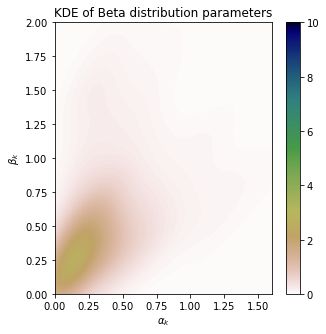

In [20]:
# Visualize
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel2(positions).T, X.shape)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               vmin=0, vmax=10, 
               cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

Excluding outliers doesn't make much of a difference, so we just let $D$ be the KDE fit on all data

In [21]:
D = kernel

In [22]:
# Sanity check: use oracle prior instead of KDE estimated above
import pickle 

path = '.cache/kde.pkl'
with open(path, 'rb') as f:
    D = pickle.load(f)

## 3. Compute $\widehat{q}_k^{EB}$ for each class $k$

The code in this section is based on `get_posterior_quantiles_oracle.py`, but many modifications have been made

In [23]:
def compute_classk_prod_f(a, b, classk_scores):
    '''
    Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    
    Inputs:
        a, b: parameters of Beta(a,b)
        class_k_scores: vector of scores for class k
    '''
    
    f_ski = beta.pdf(classk_scores, a, b)
    prod = np.prod(f_ski)
    return prod


def get_discretized_posterior_distr(k, scores, labels, grid, D_vals):
    '''
    Computes P(\alpha_k, \beta_k | s_k, D) on discretized grid
    
    Inputs: 
        - k: class (integer between 0 and 999)
        - scores, labels: vectors of equal length. scores contains the conformal scores and labels
        are the corresponding class labels
        - grid: 2 x n matrix. Each column corresponds to an (alpha, beta) pair 
        - D_vals: length-n array containing values of prior distribution evaluated on grid
        
    Output:
        length-n vector where the i-th entry is P(grid[i,0], grid[i,1] | s_k, D)
    '''

    classk_scores = scores[labels == k]
    
    # Weirdly, some scores are exactly 0 or 1, which is a problem because the Beta 
    # density blows up there for some alpha, beta values. We replace these 0 
    # values with randomly sampled values from classk_scores
    idx = (classk_scores == 0) | (classk_scores == 1)
    classk_scores[idx] = np.random.choice(classk_scores[~idx], 
                                                         size=classk_scores[idx].shape,
                                                         replace=True)
    
    prod_f = np.array([compute_classk_prod_f(grid[0,i], grid[1,i], classk_scores) 
                       for i in range(len(grid[0]))])
    prob = prod_f * D_vals

    # Replace nan entries with 0
    prob[np.isnan(prob)] = 0
    
    # Check if probability contains NaNs or infs
    if np.sum(np.isnan(prob)) + np.sum(np.isinf(prob)) > 0:
        print(f"WARNING: Probabilities for class {k} contains NaNs and/or inf")

    return prob


def generate_posterior_samples(k, scores, labels, num_samples):
    
    # Create grid for discretizing distribution
    xmin, xmax = 0, 4 # Grid bounds
    ymin, ymax = 0, 4 # Grid bounds
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Use 100 x 100 grid for now
    grid = np.vstack([X.ravel(), Y.ravel()])
    
    # Compute probabilities on discretized grid
    D_vals = D(grid)
    prob = get_discretized_posterior_distr(k, scores, labels, grid, D_vals)
    
    # Sample from discretized distribution
    normalized_prob = prob / np.sum(prob)
    
    samples = np.zeros((num_samples,))
    
    for i in range(num_samples):
        
        # a) Sample alpha_k, beta_k
        idx = np.random.choice(np.arange(len(normalized_prob)), p=normalized_prob)
        alpha_k = positions[0,idx]
        beta_k = positions[1, idx]
        
        # b) Sample score
        samples[i] = np.random.beta(alpha_k, beta_k)
        
    return samples
    

def get_quantile_and_samples(k, scores, labels, alpha, num_samples):
    
    # Generate samples
    samples = generate_posterior_samples(k, scores, labels, num_samples)
    
    # Compute quantile
    quantile = np.quantile(samples, 1-alpha, interpolation='higher') 
    
    print(f'Class {k} quantile: {quantile:.3f}')
    
    return quantile, samples

In [24]:
%%time

# This takes ~ 1h 44min. If you've already run it once, you can skip this cell and load in the values using the next cell 

qhat_and_sample_list = [get_quantile_and_samples(k, scores1, labels1, alpha, num_samples) for k in range(num_classes)]

quantiles = [x[0] for x in qhat_and_sample_list]
cached_samples = [x[1] for x in qhat_and_sample_list]

quantiles = np.array(quantiles)
cached_samples = np.array(cached_samples)

print('cached_samples.shape:', cached_samples.shape)

## Save samples
save_to = f'.cache/n={n_k}_ntune={n_k_tune}_ORACLE_cached_samples_pipeline.npy'
np.save(save_to, cached_samples)
print(f'Saved cached_samples to {save_to}')
    
## Save quantiles
print('quantiles:', quantiles)

save_to = f'.cache/n={n_k}_ntune={n_k_tune}_ORACLE_quantiles_pipeline.npy'
np.save(save_to, quantiles)
print(f'Saved quantiles to {save_to}')

Class 0 quantile: 0.913
Class 1 quantile: 0.976
Class 2 quantile: 0.992
Class 3 quantile: 0.996
Class 4 quantile: 0.994
Class 5 quantile: 0.999
Class 6 quantile: 0.979
Class 7 quantile: 0.996
Class 8 quantile: 0.993
Class 9 quantile: 0.955
Class 10 quantile: 0.974
Class 11 quantile: 0.982
Class 12 quantile: 0.999
Class 13 quantile: 0.978
Class 14 quantile: 0.936
Class 15 quantile: 0.979
Class 16 quantile: 0.979
Class 17 quantile: 0.954
Class 18 quantile: 0.957
Class 19 quantile: 0.973
Class 20 quantile: 0.916
Class 21 quantile: 0.997
Class 22 quantile: 0.963
Class 23 quantile: 0.994
Class 24 quantile: 0.919
Class 25 quantile: 0.999
Class 26 quantile: 0.998
Class 27 quantile: 0.983
Class 28 quantile: 0.959
Class 29 quantile: 0.944
Class 30 quantile: 0.996
Class 31 quantile: 0.997
Class 32 quantile: 0.994
Class 33 quantile: 0.997
Class 34 quantile: 0.996
Class 35 quantile: 0.986
Class 36 quantile: 1.000
Class 37 quantile: 0.993
Class 38 quantile: 0.967
Class 39 quantile: 0.989
Class 40 q

Class 320 quantile: 0.995
Class 321 quantile: 0.965
Class 322 quantile: 0.966
Class 323 quantile: 0.949
Class 324 quantile: 0.973
Class 325 quantile: 0.998
Class 326 quantile: 1.000
Class 327 quantile: 0.990
Class 328 quantile: 0.959
Class 329 quantile: 0.998
Class 330 quantile: 0.983
Class 331 quantile: 0.993
Class 332 quantile: 0.990
Class 333 quantile: 0.982
Class 334 quantile: 0.961
Class 335 quantile: 0.968
Class 336 quantile: 0.987
Class 337 quantile: 0.996
Class 338 quantile: 0.972
Class 339 quantile: 0.970
Class 340 quantile: 0.918
Class 341 quantile: 0.994
Class 342 quantile: 0.994
Class 343 quantile: 0.971
Class 344 quantile: 0.973
Class 345 quantile: 0.998
Class 346 quantile: 1.000
Class 347 quantile: 0.951
Class 348 quantile: 0.996
Class 349 quantile: 0.992
Class 350 quantile: 0.999
Class 351 quantile: 0.994
Class 352 quantile: 0.988
Class 353 quantile: 0.979
Class 354 quantile: 0.945
Class 355 quantile: 0.978
Class 356 quantile: 0.999
Class 357 quantile: 0.991
Class 358 qu

Class 636 quantile: 0.999
Class 637 quantile: 0.962
Class 638 quantile: 1.000
Class 639 quantile: 0.999
Class 640 quantile: 0.900
Class 641 quantile: 0.996
Class 642 quantile: 0.906
Class 643 quantile: 0.999
Class 644 quantile: 0.998
Class 645 quantile: 0.957
Class 646 quantile: 0.999
Class 647 quantile: 0.996
Class 648 quantile: 1.000
Class 649 quantile: 0.907
Class 650 quantile: 0.996
Class 651 quantile: 0.987
Class 652 quantile: 0.999
Class 653 quantile: 1.000
Class 654 quantile: 0.999
Class 655 quantile: 1.000
Class 656 quantile: 0.998
Class 657 quantile: 0.998
Class 658 quantile: 0.997
Class 659 quantile: 0.999
Class 660 quantile: 0.918
Class 661 quantile: 0.949
Class 662 quantile: 0.995
Class 663 quantile: 0.998
Class 664 quantile: 0.999
Class 665 quantile: 0.998
Class 666 quantile: 0.998
Class 667 quantile: 0.999
Class 668 quantile: 0.998
Class 669 quantile: 0.992
Class 670 quantile: 0.998
Class 671 quantile: 0.998
Class 672 quantile: 0.998
Class 673 quantile: 1.000
Class 674 qu

Class 969 quantile: 0.997
Class 970 quantile: 0.990
Class 971 quantile: 0.971
Class 972 quantile: 0.999
Class 973 quantile: 1.000
Class 974 quantile: 0.966
Class 975 quantile: 1.000
Class 976 quantile: 0.999
Class 977 quantile: 1.000
Class 978 quantile: 0.999
Class 979 quantile: 1.000
Class 980 quantile: 0.940
Class 981 quantile: 0.988
Class 982 quantile: 0.991
Class 983 quantile: 0.957
Class 984 quantile: 0.931
Class 985 quantile: 0.918
Class 986 quantile: 0.963
Class 987 quantile: 0.999
Class 988 quantile: 1.000
Class 989 quantile: 0.942
Class 990 quantile: 0.986
Class 991 quantile: 0.936
Class 992 quantile: 0.998
Class 993 quantile: 0.930
Class 994 quantile: 0.919
Class 995 quantile: 1.000
Class 996 quantile: 0.931
Class 997 quantile: 0.994
Class 998 quantile: 1.000
Class 999 quantile: 1.000
cached_samples.shape: (1000, 10000)
Saved cached_samples to .cache/n=5_ntune=1_ORACLE_cached_samples_pipeline.npy
quantiles: [0.91265161 0.97581896 0.99171389 0.99636138 0.99363466 0.9990192
 0.

In [25]:
# cached_samples = np.load(f'.cache/n={n_k}_ntune={n_k_tune}_cached_samples_pipeline.npy')
# quantiles = np.load(f'.cache/n={n_k}_ntune={n_k_tune}_quantiles_pipeline.npy')

## 3. Conformalize

Find $\tilde{\alpha}$ such that, if we let $\widehat{q}_k$ be the ($1-\tilde{\alpha}$)%-quantile of $p(s_{k,new} | s_k, D)$, the prediction sets on the $1000 n_k^{tune}$ tuning points in `scores2, labels2` achieve a marginal coverage of $1-\alpha$ 

Note: This code is copied from `apply_conformal_adjustment.py`

In [26]:
# Restrict search between (1 - alpha) +/- 0.5 to start
quantile_min = (1 - alpha) - .10
quantile_max = (1 - alpha) + .10

# ===== Perform binary search =====
# Convergence criteria: Either (1) marginal coverage is within tol of desired or (2)
# quantile_min and quantile_max differ by less than .0001, so there is no need to try 
# to get a more precise estimate
tol = 0.0005

marginal_coverage = 0
while np.abs(marginal_coverage - (1-alpha)) > tol:
    
    quantile_guess = (quantile_min +  quantile_max) / 2
    print(f"\nCurrent quantile guess: {quantile_guess:.4f}")
    print(f"Search range: [{quantile_min}, {quantile_max}]")
    
    # 1. Get qhats_k
    qhats = [np.quantile(cached_samples[k,:], quantile_guess, interpolation='higher') for k in range(num_classes)]
    
    # 2. Compute coverage using these qhats
    preds = create_cb_prediction_sets(scores2_all, qhats)
    marginal_coverage = compute_coverage(labels2, preds)
    print(f"Marginal coverage: {marginal_coverage:.4f}")
    
    if marginal_coverage > 1 - alpha:
        quantile_max = quantile_guess
    else:
        quantile_min = quantile_guess
        
    if quantile_max - quantile_min < .0001:
        quantile_guess = quantile_max # Conservative estimate, which ensures coverage
        print("Adequate precision reached; stopping early.")
        break

print("\nFINAL QUANTILE:", quantile_guess)


Current quantile guess: 0.9000
Search range: [0.8, 1.0]
Marginal coverage: 0.9620

Current quantile guess: 0.8500
Search range: [0.8, 0.9]
Marginal coverage: 0.9160

Current quantile guess: 0.8250
Search range: [0.8, 0.8500000000000001]
Marginal coverage: 0.8850

Current quantile guess: 0.8375
Search range: [0.8250000000000001, 0.8500000000000001]
Marginal coverage: 0.9020

Current quantile guess: 0.8313
Search range: [0.8250000000000001, 0.8375000000000001]
Marginal coverage: 0.8910

Current quantile guess: 0.8344
Search range: [0.83125, 0.8375000000000001]
Marginal coverage: 0.8990

Current quantile guess: 0.8359
Search range: [0.8343750000000001, 0.8375000000000001]
Marginal coverage: 0.9010

Current quantile guess: 0.8352
Search range: [0.8343750000000001, 0.8359375000000001]
Marginal coverage: 0.9000

FINAL QUANTILE: 0.83515625


In [27]:
qhats = [np.quantile(cached_samples[k,:], quantile_guess, interpolation='higher') for k in range(num_classes)]

In [28]:
# # TO TEST: load 90% quantiles back in
# qhats = np.load('.cache/quantiles_pipeline.npy')

## 4. Evaluate

Note: This code is copied from `evaluate.ipynb`

In [29]:
preds = create_cb_prediction_sets(val_scores_all, qhats)

In [30]:
# Compute coverage

marginal_cov = compute_coverage(val_labels, preds)
print(f'Marginal coverage of EB-CB: {marginal_cov*100:.2f}%')

class_specific_cov = compute_class_specific_coverage(val_labels, preds)

Marginal coverage of EB-CB: 90.43%


To make the comparison fair, I give vanilla and naive ALL of the data I use for the class-balanced version. i.e., they should also have access to the data I tuned the conformal parameter on

In [32]:
# Get baselines for comparison

# A) Vanilla conformal
vanilla_qhat = compute_qhat(calib_scores_all, calib_labels, alpha=alpha)
vanilla_preds = create_prediction_sets(val_scores_all, vanilla_qhat)

marginal_cov = compute_coverage(val_labels, vanilla_preds)
print(f'Marginal coverage of Vanilla: {marginal_cov*100:.2f}%')
vanilla_class_specific_cov = compute_class_specific_coverage(val_labels, vanilla_preds)

# B) Naive class-balanced
naivecb_qhats = compute_class_specific_qhats(calib_scores_all, calib_labels, alpha=alpha, default_qhat=np.inf)
naivecb_preds = create_cb_prediction_sets(val_scores_all, naivecb_qhats)

naivecb_marginal_cov = compute_coverage(val_labels, naivecb_preds)
print(f'Marginal coverage of Naive CB: {naivecb_marginal_cov*100:.2f}%')
naivecb_class_specific_cov = compute_class_specific_coverage(val_labels, naivecb_preds)

Marginal coverage of Vanilla: 90.08%


Marginal coverage of Naive CB: 100.00%


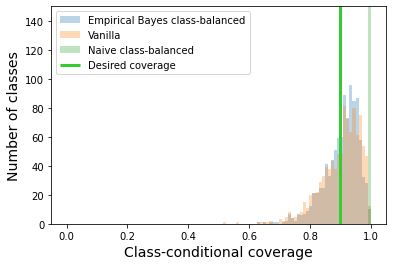

In [40]:
bins = np.linspace(0,1,100)
plt.hist(class_specific_cov, bins=bins, label="Empirical Bayes class-balanced", alpha=.3)
plt.hist(vanilla_class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
plt.hist(naivecb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)

# _, plot_ymax = plt.ylim()
plot_ymax = 150
plt.vlines(1-alpha, 0, plot_ymax, label='Desired coverage', color='limegreen', linewidth=3)
plt.ylim(0, plot_ymax)

plt.ylabel('Number of classes', fontsize=14)
plt.xlabel('Class-conditional coverage', fontsize=14)
plt.legend()
plt.show()

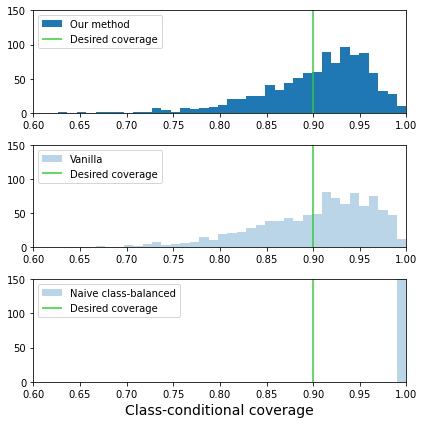

In [41]:
# The same histograms as above, except on separate plots
fig, axs = plt.subplots(3,1, figsize=(6, 6))

bins = np.linspace(0, 1, 100)
axs[0].hist(class_specific_cov, bins=bins, label="Our method")
axs[1].hist(vanilla_class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
axs[2].hist(naivecb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)

for i in range(3):
    axs[i].vlines(1-alpha, 0, plot_ymax, label='Desired coverage', color='limegreen')
    axs[i].set_ylim(0, plot_ymax)
    axs[i].set_xlim(0.6, 1)
    axs[i].legend(loc='upper left')

plt.xlabel('Class-conditional coverage', fontsize=14)
plt.tight_layout()

In [35]:
# Compute l1 distance between desired and realized coverage
l1_dist = np.sum(np.abs(class_specific_cov - (1 - alpha)))
vanilla_l1_dist = np.sum(np.abs(vanilla_class_specific_cov - (1 - alpha)))
naivecb_l1_dist = np.sum(np.abs(naivecb_class_specific_cov - (1 - alpha)))

print(f'[EB-CB] L1 distance between desired and realized class-cond. coverage: {l1_dist:.3f}')
print(f'[Vanilla] L1 distance between desired and realized class-cond. coverage: {vanilla_l1_dist:.3f}')
print(f'[Naive-CB] L1 distance between desired and realized class-cond. coverage: {naivecb_l1_dist:.3f}')

print("\nNote: The average magnitude of deviation from the desired coverage is L1 dist/1000")

[EB-CB] L1 distance between desired and realized class-cond. coverage: 44.759
[Vanilla] L1 distance between desired and realized class-cond. coverage: 52.121
[Naive-CB] L1 distance between desired and realized class-cond. coverage: 100.000

Note: The average magnitude of deviation from the desired coverage is L1 dist/1000


In [36]:
# Compute number of classes that are drastically undercovered (<80%)
thresh = 0.8

num_undercovered = np.sum(class_specific_cov < thresh)
vanilla_num_undercovered = np.sum(vanilla_class_specific_cov < thresh)
naivecb_num_undercovered = np.sum(naivecb_class_specific_cov < thresh)

print(f'[EB-CB] Number of classes that have less than 80% coverage:', num_undercovered)
print(f'[Vanilla] Number of classes that have less than 80% coverage:', 
      vanilla_num_undercovered)
print(f'[Naive-CB] Number of classes that have less than 80% coverage:', 
      naivecb_num_undercovered)

# Usign unconformalized qhats: [EB-CB] Number of classes that have less than 80% coverage: 15

[EB-CB] Number of classes that have less than 80% coverage: 51
[Vanilla] Number of classes that have less than 80% coverage: 76
[Naive-CB] Number of classes that have less than 80% coverage: 0


In [37]:
avg_set_size = compute_avg_set_size(preds)
vanilla_avg_set_size = compute_avg_set_size(vanilla_preds)
naivecb_avg_set_size = compute_avg_set_size(naivecb_preds)

print(f'[EB-CB] Average size of prediction set: {avg_set_size:.2f}')
print(f'[Vanilla] Average size of prediction set: {vanilla_avg_set_size:.2f}')
print(f'[Naive-CB] Average size of prediction set: {naivecb_avg_set_size:.2f}')

# Using unconformalized qhats: [EB-CB] Average size of prediction set: 2.99

[EB-CB] Average size of prediction set: 4.43
[Vanilla] Average size of prediction set: 1.95
[Naive-CB] Average size of prediction set: 1000.00


[EB-CB] Max prediction set size: 40
[Vanilla] Max prediction set size: 11
[Naive-CB] Max prediction set size: 1000


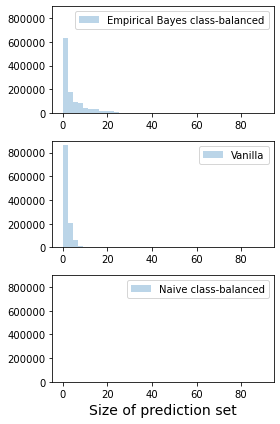

In [39]:
# Visualization of set sizes
set_sizes = [len(x) for x in preds]
vanilla_set_sizes = [len(x) for x in vanilla_preds]
naivecb_set_sizes = [len(x) for x in naivecb_preds]

print(f'[EB-CB] Max prediction set size: {np.max(set_sizes)}')
print(f'[Vanilla] Max prediction set size: {np.max(vanilla_set_sizes)}')
print(f'[Naive-CB] Max prediction set size: {np.max(naivecb_set_sizes)}')

fig, axs = plt.subplots(3,1, figsize=(4, 6))

bins = np.linspace(0, 90, 40)
# bins = np.linspace(0, 1000, 50)
axs[0].hist(set_sizes, bins=bins, label="Empirical Bayes class-balanced", alpha=.3)
axs[1].hist(vanilla_set_sizes, bins=bins, label="Vanilla", alpha=.3)
axs[2].hist(naivecb_set_sizes, bins=bins, label="Naive class-balanced", alpha=.3)

for i in range(3):
    axs[i].legend()
    axs[i].set_ylim(0, 900000)

plt.xlabel('Size of prediction set', fontsize=14)
plt.tight_layout()

# Using unconformalized qhats: [EB-CB] Max prediction set size: 28